## TFM AINHOA DÍAZ CABRERA 
Se prodecerá a realizar un estudio sobre el aumento del turismo en las islas Canarias a lo largo de los años y se hará un análisis de como esto ha afectado al coste de la vida, la saturación de recursos y servicios y el impacto medioambiental. 

Para ello contamos con varios ficheros para ver el comportamiento de todas las cosas mencionadas anteriormente. 


In [1]:
#Esta celda será para todos los import 
import numpy as np 
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from pmdarima import auto_arima
import math
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import shap

In [2]:
#En primer lugar procedemos a leer los conjuntos de datos. 

#Conjunto de datos que indican los turistas que se han hospedado en hoteles. 
hoteles = pd.read_csv('hoteles.csv', encoding='ISO-8859-1', sep=';')

#Conjunto de datos que indican los turistas que se han quedado en apartamentos turísticos. 
apar_turisticos = pd.read_csv('apartamentos_turisticos.csv', encoding = 'ISO-8859-1', sep = ';')

#Conjunto de datos que indican los gastos distintos gastos, el total, el medio por persona, etc. 
gastos = pd.read_csv('gastos.csv', encoding = 'ISO-8859-1', sep=';') 

#Conjunto de datos con información sobre los tipos de servicios. 
servicios = pd.read_csv('servicios.csv', encoding = 'ISO-8859-1', sep=';')


In [3]:
#Comprobemos que todos los tipos de datos han sido cargados adecuadamente. 
print('HOTELES \n', hoteles.dtypes, '\n')

print('APARTAMENTOS \n', apar_turisticos.dtypes, '\n')

print('GASTOS \n', gastos.dtypes, '\n')

print('SERVICIOS \n', servicios.dtypes, '\n')

HOTELES 
 Totales Territoriales                object
Comunidades y Ciudades Autónomas     object
Provincias                          float64
Viajeros y pernoctaciones            object
Residencia: Nivel 1                  object
Residencia: Nivel 2                  object
Periodo                              object
Total                                object
dtype: object 

APARTAMENTOS 
 Totales Territoriales               object
Comunidades y Ciudades Autónomas    object
Viajeros y pernoctaciones           object
Residencia: Nivel 1                 object
Residencia: Nivel 2                 object
Periodo                             object
Total                               object
dtype: object 

GASTOS 
 Comunidades  autónomas                   object
Gastos y duración media de los viajes    object
Tipo de dato                             object
Periodo                                  object
Total                                    object
dtype: object 

SERVICIOS 
 Comunidades y

In [4]:
#En primer lugar, en el conjunto de hoteles, hay que poner la fecha de forma correcta. 
#También debemos transformar el total en un entero. 
hoteles['Total'] = hoteles['Total'].astype(str).str.replace('.','').astype(int)
hoteles['Periodo'] = hoteles['Periodo'].str.replace('M', '-').str.strip()
hoteles['Periodo'] = pd.to_datetime(hoteles['Periodo'], format = '%Y-%m')
#Y volvemos a comprobar que ahora el tipo de los datos si sea correcto. 
print('HOTELES \n', hoteles.dtypes)

HOTELES 
 Totales Territoriales                       object
Comunidades y Ciudades Autónomas            object
Provincias                                 float64
Viajeros y pernoctaciones                   object
Residencia: Nivel 1                         object
Residencia: Nivel 2                         object
Periodo                             datetime64[ns]
Total                                        int32
dtype: object


In [5]:
#En apartamentos hay que realizar los mismos cambios que en hoteles. 
apar_turisticos['Total'] = apar_turisticos['Total'].astype(str).str.replace('.','').astype(int)
apar_turisticos['Periodo'] = apar_turisticos['Periodo'].str.replace('M', '-').str.strip()
apar_turisticos['Periodo'] = pd.to_datetime(apar_turisticos['Periodo'], format = '%Y-%m')
#Y volvemos a comprobar que ahora el tipo de los datos si sea correcto. 
print('APARTAMENTOS \n', apar_turisticos.dtypes)

APARTAMENTOS 
 Totales Territoriales                       object
Comunidades y Ciudades Autónomas            object
Viajeros y pernoctaciones                   object
Residencia: Nivel 1                         object
Residencia: Nivel 2                         object
Periodo                             datetime64[ns]
Total                                        int32
dtype: object


In [6]:
#En gastos también debemos cambiar el periodo y el total. 
gastos['Total'] = gastos['Total'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
gastos['Periodo'] = gastos['Periodo'].str.replace('M', '-').str.strip()
gastos['Periodo'] = pd.to_datetime(gastos['Periodo'], format = '%Y-%m') 
print('GASTOS \n', gastos.dtypes)

GASTOS 
 Comunidades  autónomas                           object
Gastos y duración media de los viajes            object
Tipo de dato                                     object
Periodo                                  datetime64[ns]
Total                                           float64
dtype: object


In [7]:
#Y por último, lo mismo para servicios. 
servicios['Total'] = servicios['Total'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
servicios['Periodo'] = servicios['Periodo'].str.replace('M', '-').str.strip()
servicios['Periodo'] = pd.to_datetime(servicios['Periodo'], format = '%Y-%m')
print('SERVICIOS \n', servicios.dtypes)

SERVICIOS 
 Comunidades y Ciudades Autónomas            object
Índice y Tasas                              object
Periodo                             datetime64[ns]
Total                                      float64
dtype: object


In [8]:
#Lo siguiente será eliminar las columnas de los Datasets que no aportan información. 
#En el conjunto de datos de hoteles, solo nos interesan los periodos y el número total de personas. 
#El resto de atributos no son relevantes. (NOTA: EXPLICAR POR QUE MÁS EN EL INFORME) 
hoteles = hoteles.drop(['Totales Territoriales', 'Comunidades y Ciudades Autónomas','Provincias', 'Viajeros y pernoctaciones',
                        'Residencia: Nivel 1', 'Residencia: Nivel 2'], axis=1)
hoteles

,Periodo,Total
0,2025-05-01,889987
1,2025-04-01,935169
2,2025-03-01,962639
3,2025-02-01,924210
4,2025-01-01,905844
...,...,...
1825,2000-05-01,2360820
1826,2000-04-01,2586932
1827,2000-03-01,2949901
1828,2000-02-01,2697008


In [9]:
#Lo mismo pasa para apartamentos. 
apar_turisticos = apar_turisticos.drop(['Totales Territoriales', 'Comunidades y Ciudades Autónomas', 'Viajeros y pernoctaciones',
                                        'Residencia: Nivel 1', 'Residencia: Nivel 2'], axis=1)
apar_turisticos

,Periodo,Total
0,2025-05-01,289969
1,2025-04-01,303151
2,2025-03-01,306724
3,2025-02-01,288845
4,2025-01-01,286786
...,...,...
1825,2000-05-01,3260727
1826,2000-04-01,4085457
1827,2000-03-01,4563126
1828,2000-02-01,4123355


In [10]:
#En el conjunto de datos de Gatos lo que no aporta información es la comunidad de residencia puesto que todos los datos son de Canarias.
#Tambiñen los gastos porque es el gasto total, y el tipo de dato que es el dato base siempre.
gastos = gastos.drop(['Comunidades  autónomas', 'Gastos y duración media de los viajes','Tipo de dato'], axis=1)
gastos

,Periodo,Total
0,2025-07-01,2219.09
1,2025-06-01,1560.65
2,2025-05-01,1519.49
3,2025-04-01,1925.15
4,2025-03-01,2428.62
...,...,...
113,2016-02-01,1261.36
114,2016-01-01,1272.47
115,2015-12-01,1198.24
116,2015-11-01,1244.74


In [11]:
#Y en el de servicios, quitamos también el de ciudades y comunidades autónomas. 
servicios = servicios.drop(['Comunidades y Ciudades Autónomas','Índice y Tasas'], axis=1)
servicios

,Periodo,Total
0,2025-06-01,154.228
1,2025-05-01,149.244
2,2025-04-01,151.980
3,2025-03-01,153.991
4,2025-02-01,143.712
...,...,...
241,2005-05-01,95.153
242,2005-04-01,99.390
243,2005-03-01,102.155
244,2005-02-01,90.624


In [12]:
#Luego hay en algunos totales de los distintos datasets viene como un 0, esto son valores perdidos. Por lo que vamos a pasarlo a Nan. 
hoteles['Total'] = hoteles['Total'].replace(0,np.nan)
apar_turisticos['Total'] = apar_turisticos['Total'].replace(0,np.nan)
gastos['Total'] = gastos['Total'].replace('Total').replace(0, np.nan) 
servicios['Total'] = servicios['Total'].replace('Total').replace(0, np.nan)

In [13]:
#Comprobemos cuantos hay. 
print(hoteles.isna().sum(), '\n')
print(apar_turisticos.isna().sum(), '\n')
print(gastos.isna().sum(), '\n')
print(servicios.isna().sum(),'\n')

Periodo    0
Total      6
dtype: int64 

Periodo     0
Total      10
dtype: int64 

Periodo    0
Total      2
dtype: int64 

Periodo    0
Total      0
dtype: int64 



In [14]:
#Imputamos usando la media 
media_Total_hot = hoteles['Total'].mean()
hoteles['Total'] = hoteles['Total'].fillna(media_Total_hot)

media_Total_apar = apar_turisticos['Total'].mean()
apar_turisticos['Total'] = apar_turisticos['Total'].fillna(media_Total_apar)

media_Total_gastos = gastos['Total'].mean()
gastos['Total'] = gastos['Total'].fillna(media_Total_gastos)

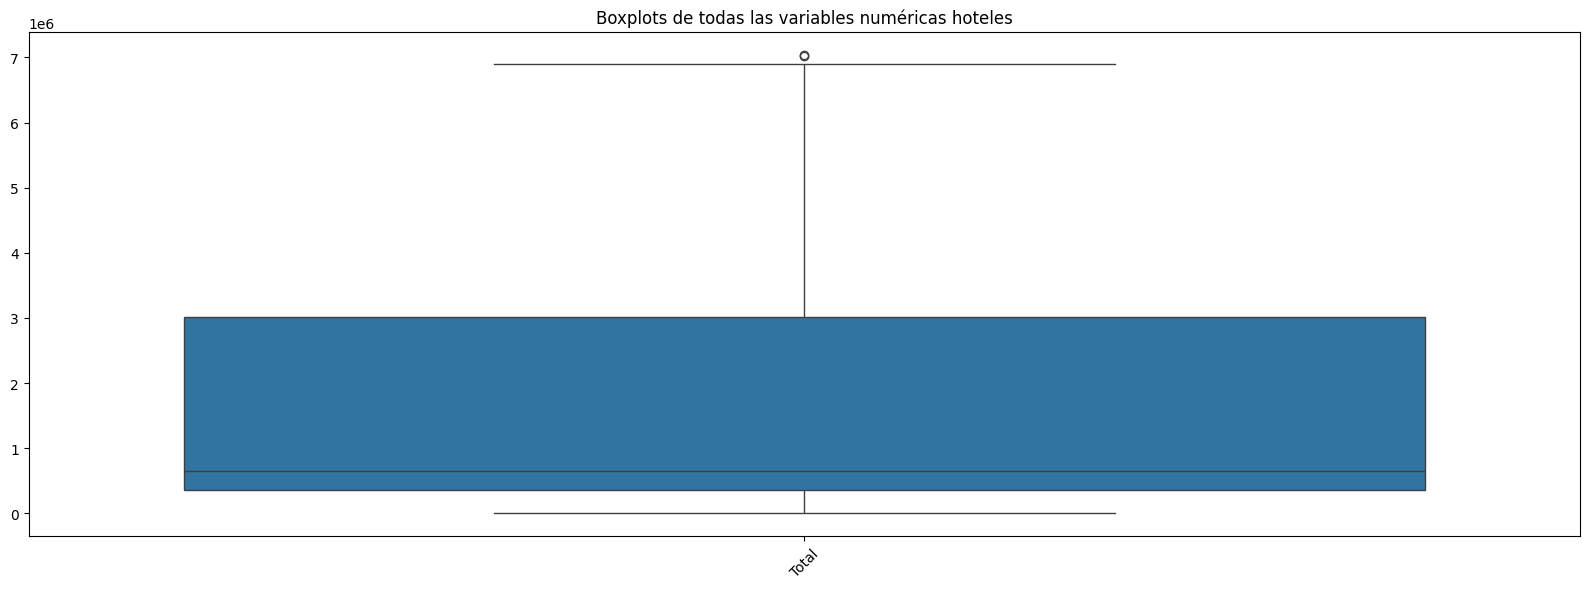

In [15]:
# Seleccionar columnas numéricas
numericas_hot = hoteles.select_dtypes(include=['int64', 'float64', 'int32'])
# Gráfico
plt.figure(figsize=(16, 6))
sns.boxplot(data=numericas_hot, orient='v')  # vertical: cada variable en el eje X
plt.title("Boxplots de todas las variables numéricas hoteles")
plt.xticks(rotation=45)  # para que los nombres de columnas no se superpongan
plt.tight_layout()
plt.show()

In [16]:
#Imputamos los outliers
for col in numericas_hot.columns:
    Q1 = hoteles[col].quantile(0.25)
    Q3 = hoteles[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    media = hoteles[col].mean()
    hoteles[col] = np.where(
        (hoteles[col] < lower_bound) | (hoteles[col] > upper_bound),
        media,
        hoteles[col]
    )


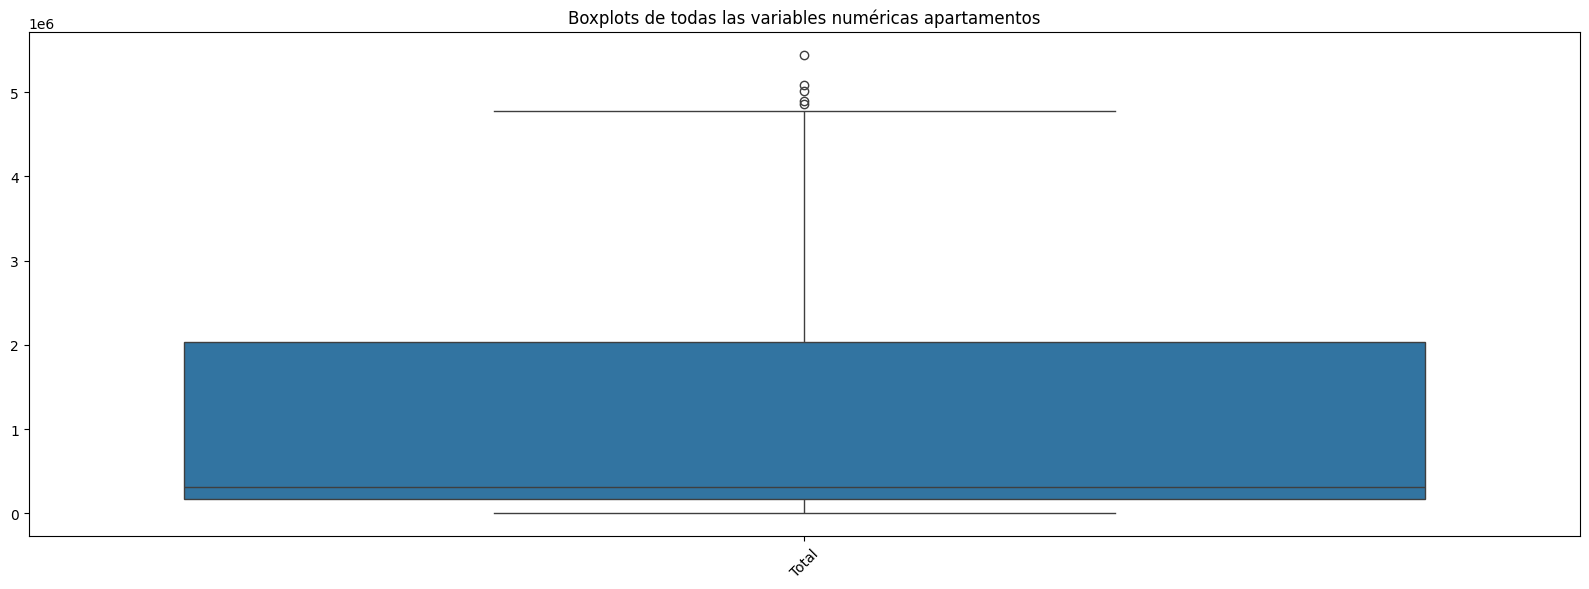

In [17]:
# Seleccionar columnas numéricas
numericas_apar = apar_turisticos.select_dtypes(include=['int64', 'float64', 'int32'])
# Gráfico
plt.figure(figsize=(16, 6))
sns.boxplot(data=numericas_apar, orient='v')  # vertical: cada variable en el eje X
plt.title("Boxplots de todas las variables numéricas apartamentos")
plt.xticks(rotation=45)  # para que los nombres de columnas no se superpongan
plt.tight_layout()
plt.show()

In [18]:
#Imputamos los outliers
for col in numericas_apar.columns:
    Q1 = apar_turisticos[col].quantile(0.25)
    Q3 = apar_turisticos[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    media = apar_turisticos[col].mean()
    apar_turisticos[col] = np.where(
        (apar_turisticos[col] < lower_bound) | (apar_turisticos[col] > upper_bound),
        media,
        apar_turisticos[col]
    )

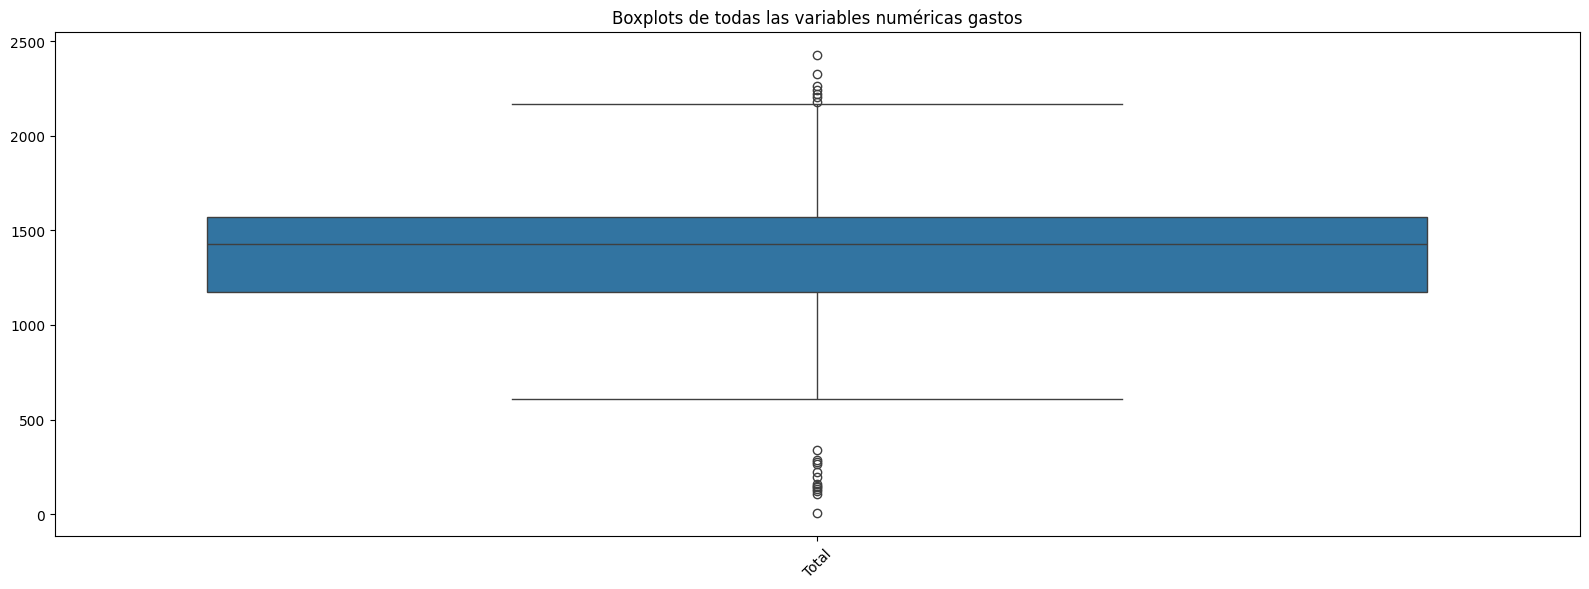

In [19]:
# Seleccionar columnas numéricas
numericas_gastos = gastos.select_dtypes(include=['int64', 'float64', 'int32'])
# Gráfico
plt.figure(figsize=(16, 6))
sns.boxplot(data=numericas_gastos, orient='v')  # vertical: cada variable en el eje X
plt.title("Boxplots de todas las variables numéricas gastos")
plt.xticks(rotation=45)  # para que los nombres de columnas no se superpongan
plt.tight_layout()
plt.show()

In [20]:
#Imputamos los outliers
for col in numericas_gastos.columns:
    Q1 = gastos[col].quantile(0.25)
    Q3 = gastos[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    media = gastos[col].mean()
    gastos[col] = np.where(
        (gastos[col] < lower_bound) | (gastos[col] > upper_bound),
        media,
        gastos[col]
    )

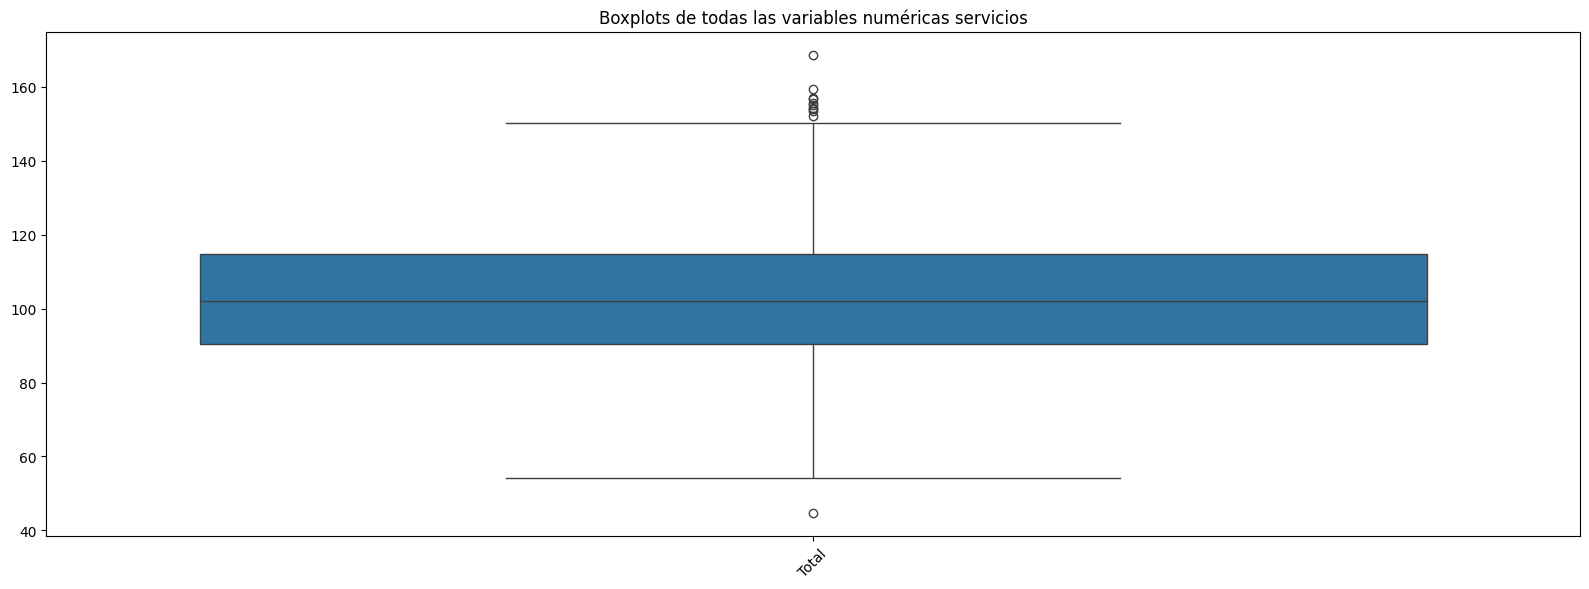

In [21]:
# Seleccionar columnas numéricas
numericas_ser = servicios.select_dtypes(include=['int64', 'float64', 'int32'])
# Gráfico
plt.figure(figsize=(16, 6))
sns.boxplot(data=numericas_ser, orient='v')  # vertical: cada variable en el eje X
plt.title("Boxplots de todas las variables numéricas servicios")
plt.xticks(rotation=45)  # para que los nombres de columnas no se superpongan
plt.tight_layout()
plt.show()

In [22]:
#Imputamos los outliers
for col in numericas_ser.columns:
    Q1 = servicios[col].quantile(0.25)
    Q3 = servicios[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    media = servicios[col].mean()
    servicios[col] = np.where(
        (servicios[col] < lower_bound) | (servicios[col] > upper_bound),
        media,
        servicios[col]
    )

In [23]:
#Vamos a sumar los totales por periodo.
# Hoteles
hoteles_unid = hoteles.groupby('Periodo', as_index=False)['Total'].sum()
hoteles_unid = hoteles_unid.rename(columns={'Total': 'Total_hoteles'})

# Apartamentos
apar_unid = apar_turisticos.groupby('Periodo', as_index=False)['Total'].sum()
apar_unid = apar_unid.rename(columns={'Total': 'Total_apartamentos'})

#Gastos y servicios no hace falta porque solo hay un valor total por periodo. 


In [24]:
#De ahora en adelante para facilidad de uso, vamos a juntar los ficheros de hoteles y apartamentos. 
#Esto tiene sentido puesto que tienen los mismos periodos y además aportan la misma información, la de turistas. 
hot_apar = pd.merge(hoteles_unid, apar_unid, on = 'Periodo', how = 'outer')
print(hot_apar.head(15))

      Periodo  Total_hoteles  Total_apartamentos
0  2000-01-01      6400906.0        9.900594e+06
1  2000-02-01      6896294.0        9.433640e+06
2  2000-03-01      7572740.0        1.038907e+07
3  2000-04-01      7101096.0        9.671262e+06
4  2000-05-01      6326106.0        7.536650e+06
5  2000-06-01      6437326.0        8.598270e+06
6  2000-07-01      7402876.0        7.071604e+06
7  2000-08-01      8334372.0        7.463048e+06
8  2000-09-01      7214918.0        9.830352e+06
9  2000-10-01      7678038.0        1.000689e+07
10 2000-11-01      7333544.0        9.823572e+06
11 2000-12-01      6605018.0        9.408292e+06
12 2001-01-01      6695180.0        9.317220e+06
13 2001-02-01      6835608.0        9.463870e+06
14 2001-03-01      7671487.0        1.000602e+07


In [25]:
#Podemos crear nuevas variables que nos aporten información importante. 
#Creamos el total de alojamientos que se han usado 
hot_apar['Total_alojamientos'] = hot_apar['Total_hoteles'] + hot_apar['Total_apartamentos']

#Porcentaje que representan los hoteles y los apartamentos respecto al total. 
hot_apar['Pct_hoteles'] = hot_apar['Total_hoteles'] / hot_apar['Total_alojamientos']*100
hot_apar['Pct_apar'] = hot_apar['Total_apartamentos'] / hot_apar['Total_alojamientos']*100

#Vaciación mensual 
hot_apar['Cambio_mensual_hot'] = hot_apar['Total_hoteles'].pct_change() * 100
hot_apar['Cambio_mensual_apar'] = hot_apar['Total_apartamentos'].pct_change() * 100


In [26]:
hot_apar_gastos = pd.merge(hot_apar, gastos, on = 'Periodo', how = 'inner') 
#Renombramos columna de total de gastos
hot_apar_gastos = hot_apar_gastos.rename(columns={'Total': 'Total_gastos'})
print(hot_apar_gastos.head(10))

     Periodo  Total_hoteles  Total_apartamentos  Total_alojamientos  \
0 2015-10-01     12843401.0           5847497.0          18690898.0   
1 2015-11-01     12232459.0           5909952.0          18142411.0   
2 2015-12-01     11960208.0           5955595.0          17915803.0   
3 2016-01-01     12465286.0           6179472.0          18644758.0   
4 2016-02-01     12365275.0           6055293.0          18420568.0   
5 2016-03-01     13531268.0           6541713.0          20072981.0   
6 2016-04-01     12140325.0           5212302.0          17352627.0   
7 2016-05-01     11826407.0           4779255.0          16605662.0   
8 2016-06-01     12370258.0           5211943.0          17582201.0   
9 2016-07-01     14966340.0           6883329.0          21849669.0   

   Pct_hoteles   Pct_apar  Cambio_mensual_hot  Cambio_mensual_apar  \
0    68.714735  31.285265            7.137139            11.638834   
1    67.424660  32.575340           -4.756855             1.068064   
2    66.

In [27]:
hot_apar_gastos

,Periodo,Total_hoteles,Total_apartamentos,Total_alojamientos,Pct_hoteles,Pct_apar,Cambio_mensual_hot,Cambio_mensual_apar,Total_gastos
0,2015-10-01,12843401.0,5847497.0,18690898.0,68.714735,31.285265,7.137139,11.638834,1149.710000
1,2015-11-01,12232459.0,5909952.0,18142411.0,67.424660,32.575340,-4.756855,1.068064,1244.740000
2,2015-12-01,11960208.0,5955595.0,17915803.0,66.757867,33.242133,-2.225644,0.772307,1198.240000
3,2016-01-01,12465286.0,6179472.0,18644758.0,66.856786,33.143214,4.222987,3.759104,1272.470000
4,2016-02-01,12365275.0,6055293.0,18420568.0,67.127545,32.872455,-0.802316,-2.009541,1261.360000
...,...,...,...,...,...,...,...,...,...
111,2025-01-01,14340910.0,5775380.0,20116290.0,71.290034,28.709966,4.031570,14.355152,2170.580000
112,2025-02-01,13798044.0,5477170.0,19275214.0,71.584388,28.415612,-3.785436,-5.163470,1346.306379
113,2025-03-01,14204067.0,5648298.0,19852365.0,71.548488,28.451512,2.942613,3.124387,1346.306379
114,2025-04-01,13324568.0,5042539.0,18367107.0,72.545818,27.454182,-6.191882,-10.724629,1925.150000


In [28]:
hot_apar_serv = pd.merge(hot_apar, servicios, on = 'Periodo', how = 'inner') 
#Renombramos columna de servicios 
hot_apar_serv = hot_apar_serv.rename(columns={'Total': 'Total_servicios'})
print(hot_apar_serv.head(10))

     Periodo  Total_hoteles  Total_apartamentos  Total_alojamientos  \
0 2005-01-01      7514419.0           7843560.0          15357979.0   
1 2005-02-01      6944795.0           7493015.0          14437810.0   
2 2005-03-01      7388356.0           8239455.0          15627811.0   
3 2005-04-01      6378573.0           5707320.0          12085893.0   
4 2005-05-01      5893225.0           4669232.0          10562457.0   
5 2005-06-01      6155004.0           5106376.0          11261380.0   
6 2005-07-01      7891262.0           7270651.0          15161913.0   
7 2005-08-01      9546188.0           9033272.0          18579460.0   
8 2005-09-01      7500876.0           6489836.0          13990712.0   
9 2005-10-01      7785842.0           7093266.0          14879108.0   

   Pct_hoteles   Pct_apar  Cambio_mensual_hot  Cambio_mensual_apar  \
0    48.928436  51.071564           12.143707             4.720315   
1    48.101443  51.898557           -7.580413            -4.469208   
2    47.

In [29]:
#También vamos a crear un conjunto con todos los datos que puede ser útil. 
hot_apar_gast_serv = pd.merge(hot_apar_gastos, servicios, on = 'Periodo', how = 'inner') 
#Renombramos columna de servicios 
hot_apar_gast_serv = hot_apar_gast_serv.rename(columns={'Total': 'Total_servicios'})
print(hot_apar_gast_serv.head(10))

     Periodo  Total_hoteles  Total_apartamentos  Total_alojamientos  \
0 2015-10-01     12843401.0           5847497.0          18690898.0   
1 2015-11-01     12232459.0           5909952.0          18142411.0   
2 2015-12-01     11960208.0           5955595.0          17915803.0   
3 2016-01-01     12465286.0           6179472.0          18644758.0   
4 2016-02-01     12365275.0           6055293.0          18420568.0   
5 2016-03-01     13531268.0           6541713.0          20072981.0   
6 2016-04-01     12140325.0           5212302.0          17352627.0   
7 2016-05-01     11826407.0           4779255.0          16605662.0   
8 2016-06-01     12370258.0           5211943.0          17582201.0   
9 2016-07-01     14966340.0           6883329.0          21849669.0   

   Pct_hoteles   Pct_apar  Cambio_mensual_hot  Cambio_mensual_apar  \
0    68.714735  31.285265            7.137139            11.638834   
1    67.424660  32.575340           -4.756855             1.068064   
2    66.

In [30]:
#También podemos añadir variables temporales, además de lags y medias móviles que
#pueden ayudar aportando información temporal extra. 
hot_apar['Mes'] = hot_apar['Periodo'].dt.month
hot_apar['Trimestre'] = hot_apar['Periodo'].dt.quarter 

hot_apar['lag1'] = hot_apar['Total_alojamientos'].shift(1)
hot_apar['lag3'] = hot_apar['Total_alojamientos'].shift(3)
hot_apar['rolling3'] = hot_apar['Total_alojamientos'].rolling(3).mean()

Hemos acabado la depuración de los datos. Lo siguiente será proceder con el análisis descriptivo y las visualizaciones, viendo posibles relaciones y tendencias temporales. 


In [31]:
#Veamos primero los estadísticos básicos. 
print(hot_apar.describe())

                             Periodo  Total_hoteles  Total_apartamentos  \
count                            305   3.050000e+02        3.050000e+02   
mean   2012-08-31 04:33:50.163934464   9.978179e+06        6.009432e+06   
min              2000-01-01 00:00:00   1.458300e+04        7.755700e+04   
25%              2006-05-01 00:00:00   7.572740e+06        4.972850e+06   
50%              2012-09-01 00:00:00   1.023367e+07        5.909952e+06   
75%              2019-01-01 00:00:00   1.245882e+07        7.103002e+06   
max              2025-05-01 00:00:00   1.581748e+07        1.041368e+07   
std                              NaN   3.111680e+06        1.917786e+06   

       Total_alojamientos  Pct_hoteles    Pct_apar  Cambio_mensual_hot  \
count        3.050000e+02   305.000000  305.000000          304.000000   
mean         1.598761e+07    61.967086   38.032914           12.435719   
min          1.622100e+05     0.357585   23.601763          -99.854364   
25%          1.493469e+07   

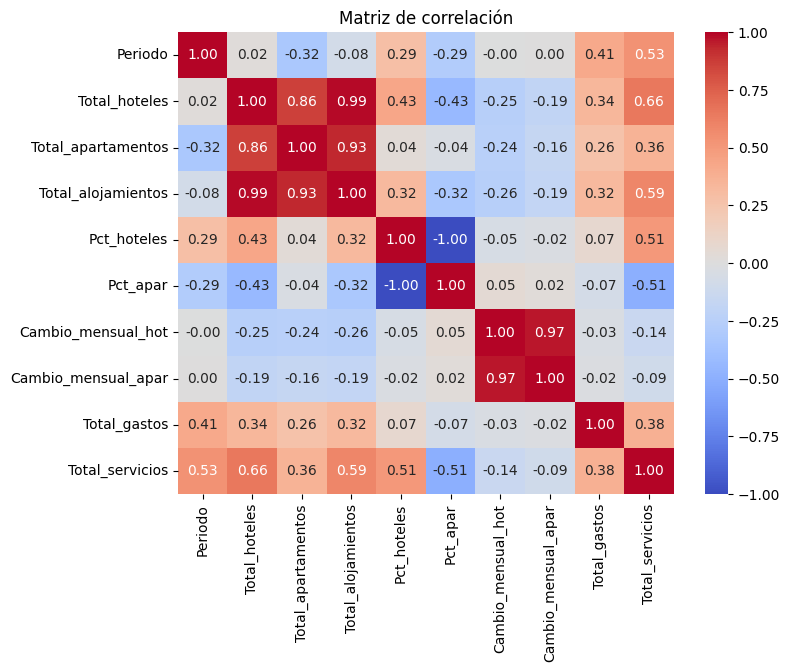

In [32]:
#Lo siguiente será ver la correlación que tenemos entre las variables. 
plt.figure(figsize=(8,6))
sns.heatmap(hot_apar_gast_serv.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

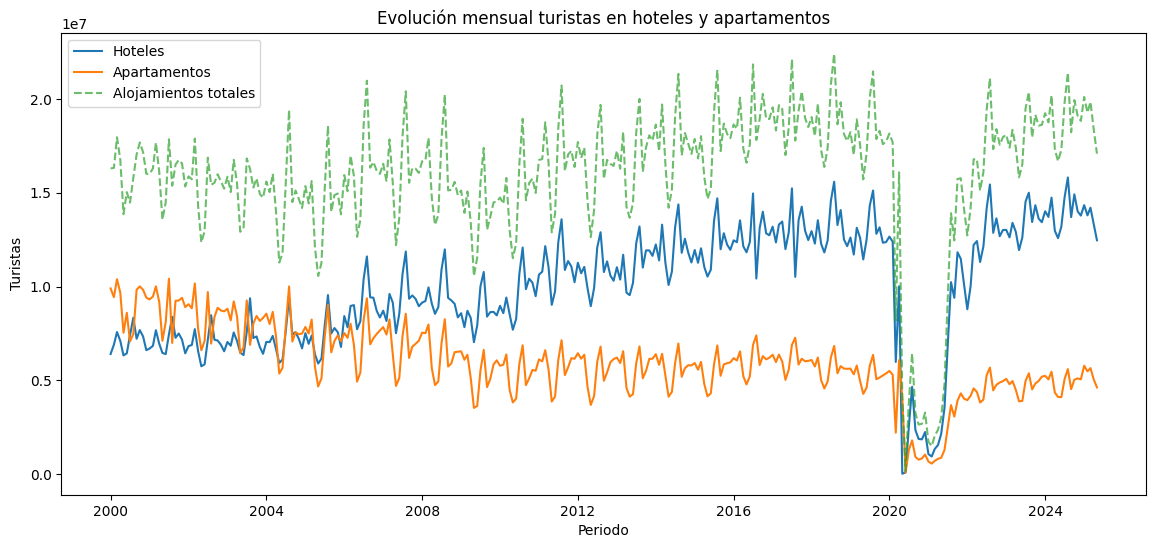

In [33]:
#Veamos la evolución mensual de los turistas en hoteles y apartamentos. 
plt.figure(figsize=(14,6))
plt.plot(hot_apar['Periodo'], hot_apar['Total_hoteles'], label = 'Hoteles')
plt.plot(hot_apar['Periodo'],hot_apar['Total_apartamentos'], label = 'Apartamentos')
plt.plot(hot_apar['Periodo'], hot_apar['Total_alojamientos'], label = 'Alojamientos totales', linestyle='--', alpha=0.7)
plt.title('Evolución mensual turistas en hoteles y apartamentos')
plt.xlabel('Periodo')
plt.ylabel('Turistas')
plt.legend()
plt.show()


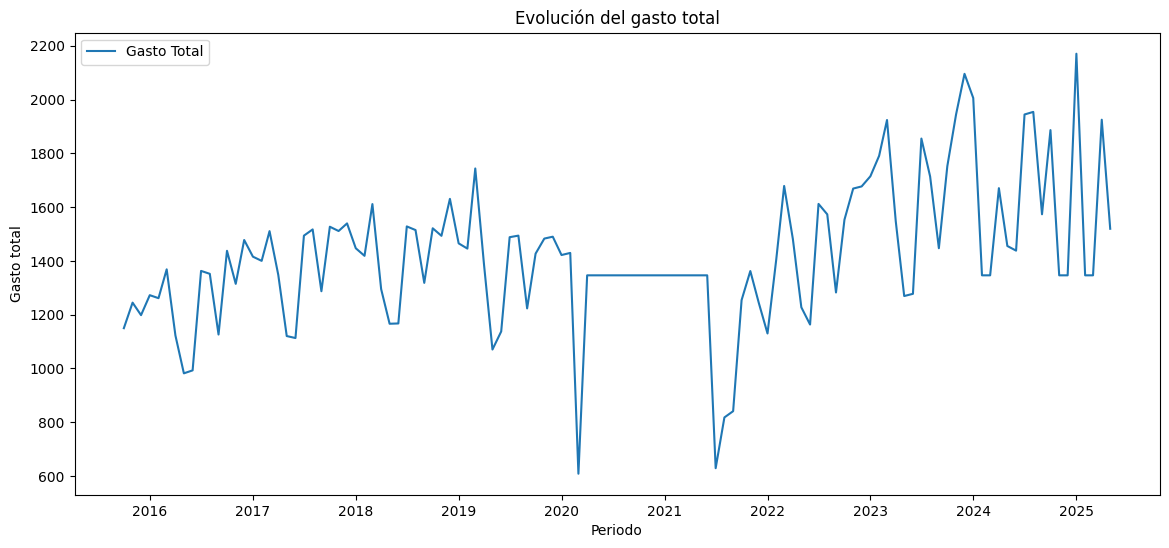

In [34]:
#Ahora veamos gráficamente la evolución del gasto total. 
plt.figure(figsize=(14,6))
plt.plot(hot_apar_gastos['Periodo'], hot_apar_gastos['Total_gastos'], label = 'Gasto Total')
plt.title('Evolución del gasto total')
plt.xlabel('Periodo')
plt.ylabel('Gasto total')
plt.legend()
plt.show()

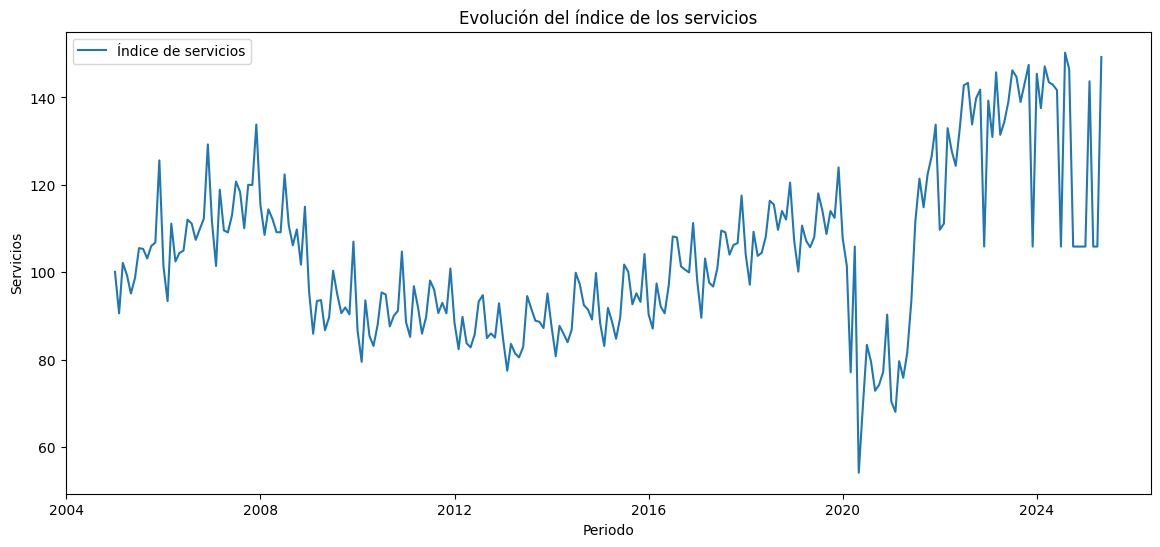

In [35]:
#Y veamos también la evolución de los servicios 
plt.figure(figsize=(14,6))
plt.plot(hot_apar_serv['Periodo'], hot_apar_serv['Total_servicios'], label = 'Índice de servicios')
plt.title('Evolución del índice de los servicios')
plt.xlabel('Periodo')
plt.ylabel('Servicios')
plt.legend()
plt.show()

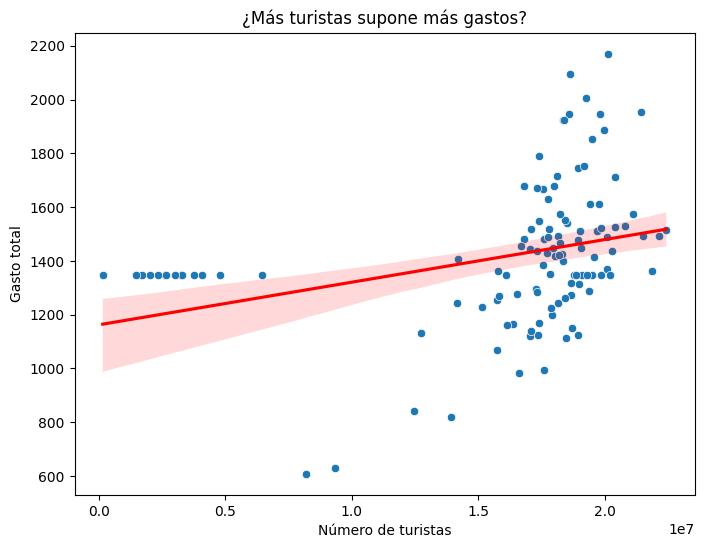

In [36]:
#Veamos ahora las relaciones entre los datos. 
#Relación entre turistas y gasto total. 
plt.figure(figsize=(8,6))
sns.scatterplot(data=hot_apar_gastos, x='Total_alojamientos', y='Total_gastos')
sns.regplot(data=hot_apar_gastos, x='Total_alojamientos', y='Total_gastos', scatter=False, color='red')
plt.title('¿Más turistas supone más gastos?')
plt.xlabel('Número de turistas')
plt.ylabel('Gasto total')
plt.show()

In [37]:
#Podemos observar la correlación de forma numérica. 
print(hot_apar_gastos[['Total_alojamientos', 'Total_gastos']].corr())

                    Total_alojamientos  Total_gastos
Total_alojamientos            1.000000      0.322891
Total_gastos                  0.322891      1.000000


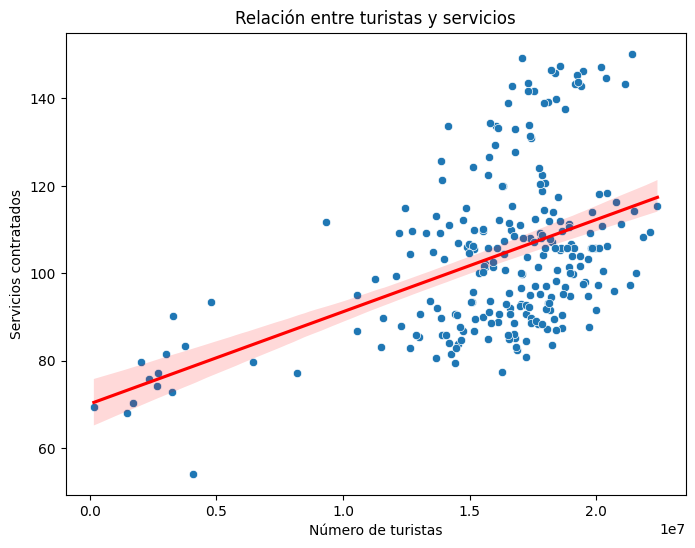

In [38]:
#Otra cosa a observar es la relación entre los turistas y los servicios contratados, lo que puede tener impacto socioeconómico y ambiental. 
plt.figure(figsize=(8,6))
sns.scatterplot(data=hot_apar_serv, x='Total_alojamientos', y='Total_servicios')
sns.regplot(data=hot_apar_serv, x='Total_alojamientos', y='Total_servicios', scatter=False, color= 'red')
plt.title('Relación entre turistas y servicios' )
plt.xlabel('Número de turistas')
plt.ylabel('Servicios contratados') 
plt.show()


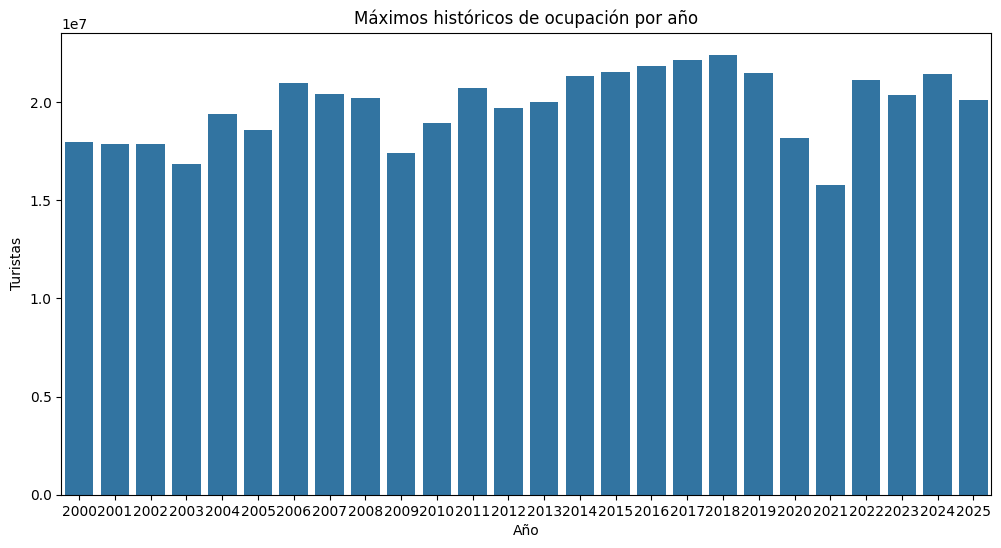

In [39]:
#Podemos ver también los años que hay picos de saturación, osea máximos de ocupación. 
hot_apar['Año'] = hot_apar['Periodo'].dt.year
picos = hot_apar.groupby('Año')['Total_alojamientos'].max().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=picos, x='Año', y= 'Total_alojamientos') 
plt.title('Máximos históricos de ocupación por año') 
plt.xlabel('Año')
plt.ylabel('Turistas')
plt.show()


# Modelización predictiva
Lo siguiente a realizar será aplicar los modelos de machine learning. 
Queremos predecir el número de turistas, que es útil para planificar el turismo y el gasto total, muy importante para el impacto económico 

In [40]:
#Primero debemos convertir variables temporales en características útiles para nuestros modelos. 
#Para ello realizamos una copia de nuestro dataset combinado con todos. 
df_combinado = hot_apar_gast_serv.copy()
#Extraemos año, mes que será en función de lo que se predecirá el número de turistas y los gastos totales. 
df_combinado['Año'] = df_combinado['Periodo'].dt.year
df_combinado['Mes'] = df_combinado['Periodo'].dt.month

#Determinamos las variables predictoras, debido a que la suma de hoteles y apartamentos da los alojamientos, 
#no podemos usarlas para predecir
X_turis = df_combinado[['Año', 'Mes', 'Total_servicios']]
#Variables que queremos predecir 
y_turistas = df_combinado['Total_alojamientos']

#Determinamos las variables predictoras
X_gas = df_combinado[['Año', 'Mes', 'Total_hoteles', 'Total_apartamentos', 'Total_servicios']]
#Variable a predecir
y_gastos = df_combinado['Total_gastos']

In [41]:
#Primero realizaremos una regresión lineal, para ello debemos separar entre train y test. 
X_train_turis, X_test_turis, y_train_turis, y_test_turis = train_test_split(X_turis, y_turistas, test_size=0.2, shuffle=False)

#Creamos el modelo
regresionLineal_turis = LinearRegression()
regresionLineal_turis.fit(X_train_turis, y_train_turis)


LinearRegression()

In [42]:
#Realizamos las predicciones del modelo 
y_pred_turisLin = regresionLineal_turis.predict(X_test_turis)

#Calculamos las métricas: 
mae_turis_lin = mean_absolute_error(y_test_turis, y_pred_turisLin) 
rmse_turis_lin = np.sqrt(mean_squared_error(y_test_turis, y_pred_turisLin))
r2_turis_lin = r2_score(y_test_turis, y_pred_turisLin)

print('Regresión lineal')
print('Mae', mae_turis_lin, 'Rmse', rmse_turis_lin, 'R2', r2_turis_lin)

Regresión lineal
Mae 5750148.416280508 Rmse 8520574.237438295 R2 -47.594518130182735


In [43]:
#El siguiente será el modelo gridsearch con random forest
#Definimos la rejilla de parámetros a probar 
param_grid={'n_estimators':[100,200,300],
            'max_depth':[5,10,None],
            'min_samples_split':[2,5],
            'min_samples_leaf':[1,2]}
#GridSearchCV con random forest 
tscv = TimeSeriesSplit(n_splits=5)
grid_turisRf = GridSearchCV(RandomForestRegressor(random_state=42), 
                       param_grid, 
                       cv= tscv, 
                       scoring= 'neg_mean_absolute_error', 
                       n_jobs=-1)
#Entrenamos el gridSearch
grid_turisRf.fit(X_train_turis, y_train_turis)
#Elegimos mejor modelo. 
best_turis_rf = grid_turisRf.best_estimator_
#Predicciones
y_pred_turisRf = best_turis_rf.predict(X_test_turis)

mae_turis_rf = mean_absolute_error(y_test_turis, y_pred_turisRf)
rmse_turis_rf = np.sqrt(mean_squared_error(y_test_turis, y_pred_turisRf))
r2_turis_rf = r2_score(y_test_turis, y_pred_turisRf)

print('Random Forest Optimizado')
print('Mae', mae_turis_rf, 'Rmse', rmse_turis_rf, 'R2', r2_turis_rf)

Random Forest Optimizado
Mae 1894721.1370496545 Rmse 2360971.0360368486 R2 -2.7310482820289446


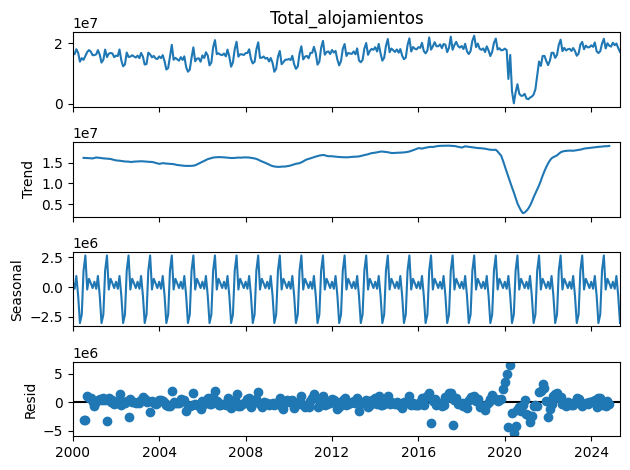

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7799.821, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7681.139, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7691.002, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7797.823, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=7796.284, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=7680.449, Time=0.74 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=7676.447, Time=1.07 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=7675.545, Time=0.39 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=7709.786, Time=0.21 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=7675.941, Time=0.94 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=7701.222, Time=0.61 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=7677.402, Time=1.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=7690.721, Time=0.41 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=7651.415, Time=0.67 sec
 ARIMA(2,1,0)(0,0,1

In [44]:
#Realizamos serie temporal usando el modelo ARIMA
serie_turistas = hot_apar.set_index('Periodo')['Total_alojamientos'].asfreq('MS')
#Antes vamos a realizar una descomposición de serie temporal. 
descomposi_turis = seasonal_decompose(serie_turistas, model='additive')
descomposi_turis.plot()
plt.show()

#Separamos en train y test 
train_size_turis= int(len(serie_turistas)*0.8)
train_turisAR, test_turisAR = serie_turistas[:train_size_turis], serie_turistas[train_size_turis:]

#Debemos ajustar automáticamente el modelo ARIMA  
modelo_auto = auto_arima(train_turisAR, 
                         start_p=0, start_q=0, max_p=3, max_q=3, 
                         start_P=0, start_Q=0, max_P=2, max_Q=2, 
                         seasonal=True, m=12, d=None, D=None, trace=True, 
                         error_action='ignore', suppress_warnings=True, 
                         stepwise=True)
print(modelo_auto.summary())

#predecimos sobre el test
pred_turis = modelo_auto.predict(n_periods=len(test_turisAR))

#Evaluamos 
mae_turisAR = mean_absolute_error(test_turisAR, pred_turis)
rmse_turisAR = math.sqrt(mean_squared_error(test_turisAR, pred_turis))

print('ARIMA')
print('Mae', mae_turisAR)
print('Rmse', rmse_turisAR)

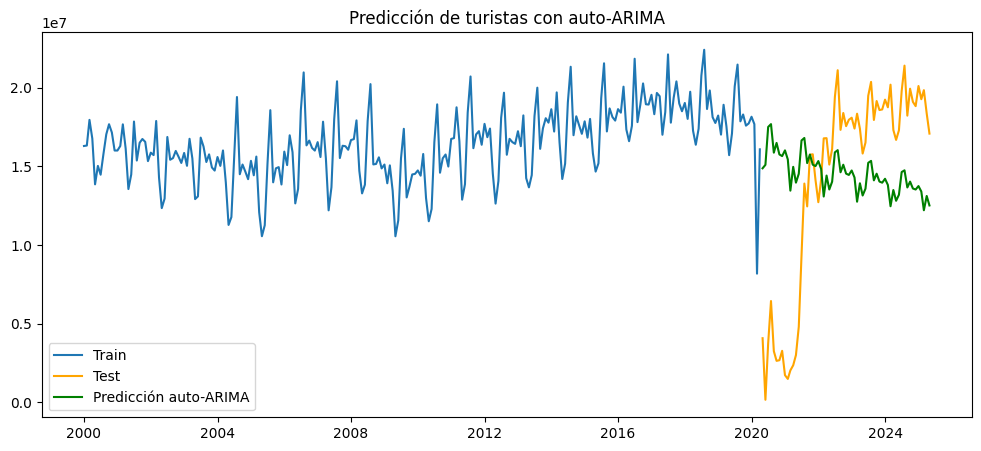

In [45]:
#Visualizamos test vs predicciones 
plt.figure(figsize=(12,5))
plt.plot(train_turisAR.index, train_turisAR, label='Train')
plt.plot(test_turisAR.index, test_turisAR, label='Test', color='orange')
plt.plot(test_turisAR.index, pred_turis, label= 'Predicción auto-ARIMA', color = 'green') 
plt.legend()
plt.title('Predicción de turistas con auto-ARIMA')
plt.show()

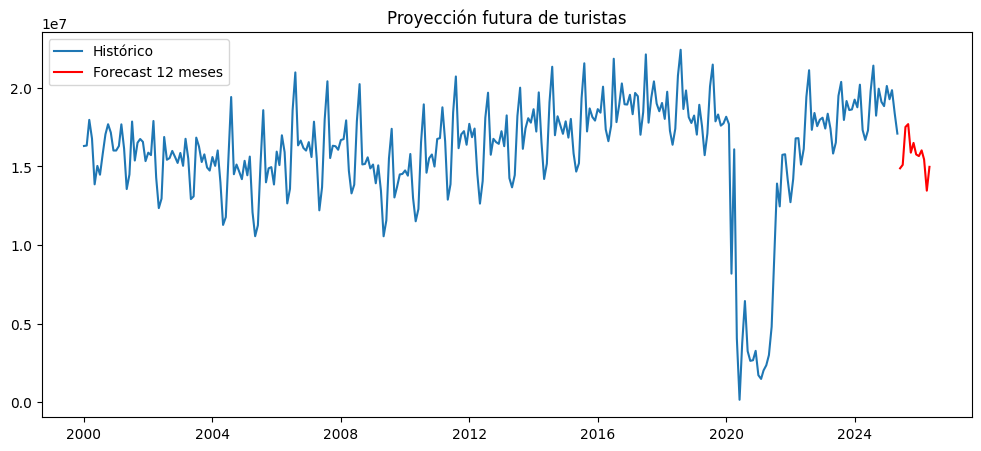

In [46]:
#Calculamos el forecast futuro. 
forecast = modelo_auto.predict(n_periods=12)

plt.figure(figsize = (12,5))
plt.plot(serie_turistas.index, serie_turistas, label = 'Histórico')
plt.plot(pd.date_range(serie_turistas.index[-1] + pd.offsets.MonthBegin(), periods = 12, freq = 'MS'),
         forecast, label = 'Forecast 12 meses', color = 'red') 
plt.legend()
plt.title('Proyección futura de turistas')
plt.show()

In [47]:
#Primero realizaremos una regresión lineal, para ello debemos separar entre train y test. 
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gastos, test_size=0.2, shuffle=False)

#Creamos el modelo
regresionLineal_gas = LinearRegression()
regresionLineal_gas.fit(X_train_gas, y_train_gas)


LinearRegression()

In [48]:
#Realizamos las predicciones del modelo 
y_pred_gasLin = regresionLineal_gas.predict(X_test_gas)

#Calculamos las métricas: 
mae_gas_lin = mean_absolute_error(y_test_gas, y_pred_gasLin) 
rmse_gas_lin = np.sqrt(mean_squared_error(y_test_gas, y_pred_gasLin))
r2_gas_lin = r2_score(y_test_gas, y_pred_gasLin)

print('Regresión lineal')
print('Mae', mae_gas_lin, 'Rmse', rmse_gas_lin, 'R2', r2_gas_lin)

Regresión lineal
Mae 248.415554447997 Rmse 279.1283413644523 R2 0.010332612265888774


In [49]:
#El siguiente será el modelo Random Forest 
#Definimos la rejilla de parámetros a probar 
param_grid={'n_estimators':[100,200,300],
            'max_depth':[5,10,None],
            'min_samples_split':[2,5],
            'min_samples_leaf':[1,2]}
#GridSearchCV con random forest 
tscv_gas = TimeSeriesSplit(n_splits=5)
grid_gasRf = GridSearchCV(RandomForestRegressor(random_state=42), 
                       param_grid, 
                       cv= tscv_gas, 
                       scoring= 'neg_mean_absolute_error', 
                       n_jobs=-1)
#Entrenamos el gridSearch
grid_gasRf.fit(X_train_gas, y_train_gas)
#Elegimos mejor modelo. 
best_gas_rf = grid_gasRf.best_estimator_
#Predicciones
y_pred_gasRf = best_gas_rf.predict(X_test_gas)

mae_gas_rf = mean_absolute_error(y_test_gas, y_pred_gasRf)
rmse_gas_rf = np.sqrt(mean_squared_error(y_test_gas, y_pred_gasRf))
r2_gas_rf = r2_score(y_test_gas, y_pred_gasRf)

print('Random Forest Optimizado')
print('Mae', mae_gas_rf, 'Rmse', rmse_gas_rf, 'R2', r2_gas_rf)



Random Forest Optimizado
Mae 257.36330570650676 Rmse 302.78666983685565 R2 -0.16454129236487125


In [50]:
#NO HACEMOS ARIMA PORQUE NO ES SERIE ESTACIONAL COMO LA OTRA, NO HAY UN PATRÓN CLARO

In [51]:
#Comparamos los resultados en una tabla
resultados = pd.DataFrame({ 'Modelo': ['Regresión Lineal', 'Random Forest', 'Regresión Lineal', 'Random Forest'],
                           'Variable': ['Turistas', 'Turistas', 'Gastos', 'Gastos'],
                           'MAE': [mae_turis_lin, mae_turis_rf, mae_gas_lin, mae_gas_rf],
                           'RMSE':[rmse_turis_lin, rmse_turis_rf, rmse_gas_lin, rmse_gas_rf],
                           'R2': [r2_turis_lin, r2_turis_rf, r2_gas_lin, r2_gas_rf]})
print(resultados)

             Modelo  Variable           MAE          RMSE         R2
0  Regresión Lineal  Turistas  5.750148e+06  8.520574e+06 -47.594518
1     Random Forest  Turistas  1.894721e+06  2.360971e+06  -2.731048
2  Regresión Lineal    Gastos  2.484156e+02  2.791283e+02   0.010333
3     Random Forest    Gastos  2.573633e+02  3.027867e+02  -0.164541


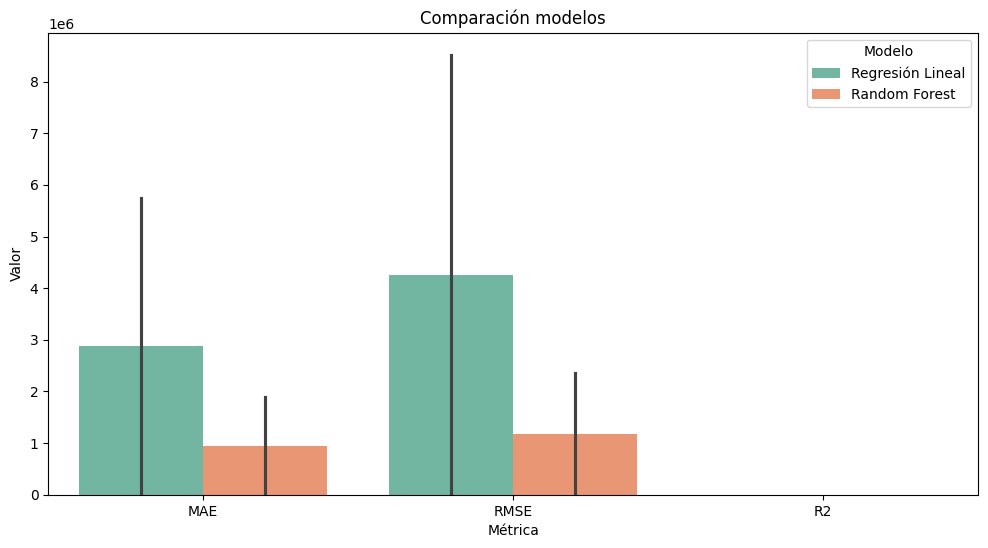

In [52]:
#Y ahora comparamos con un gráfico de barras. 
result = resultados.melt(id_vars=['Modelo', 'Variable'], value_vars=['MAE', 'RMSE', 'R2'],
                         var_name= 'Métrica', value_name='Valor')
plt.figure(figsize=(12,6))
sns.barplot(data= result, x='Métrica', y='Valor', hue='Modelo', dodge=True, palette='Set2')
plt.title('Comparación modelos')
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.legend(title='Modelo')
plt.show()

# Interpretabilidad

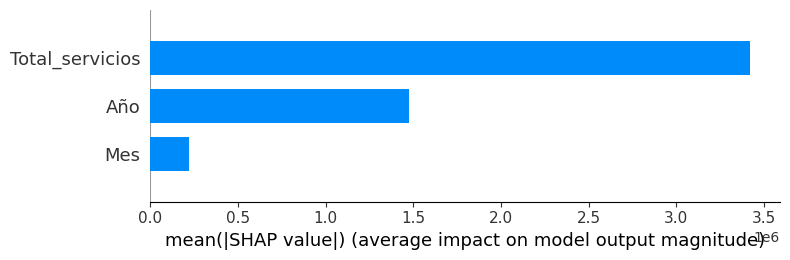

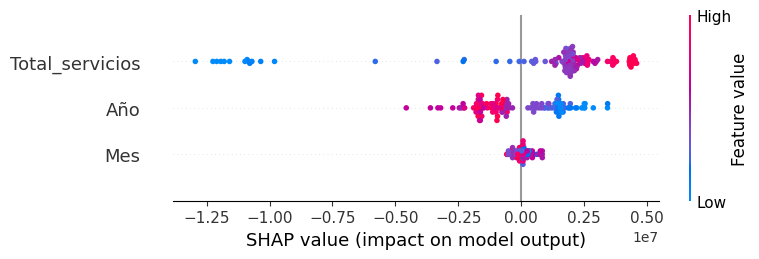

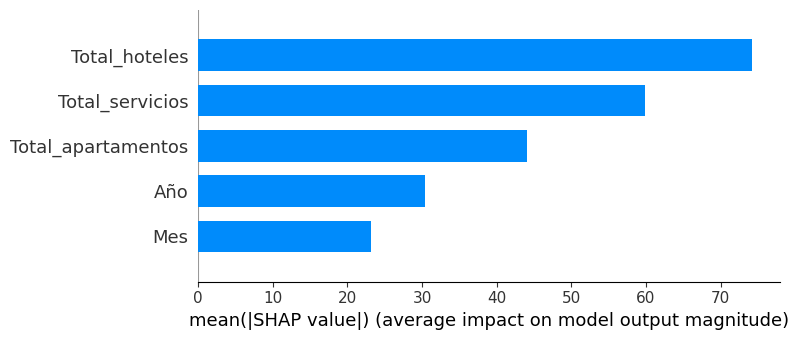

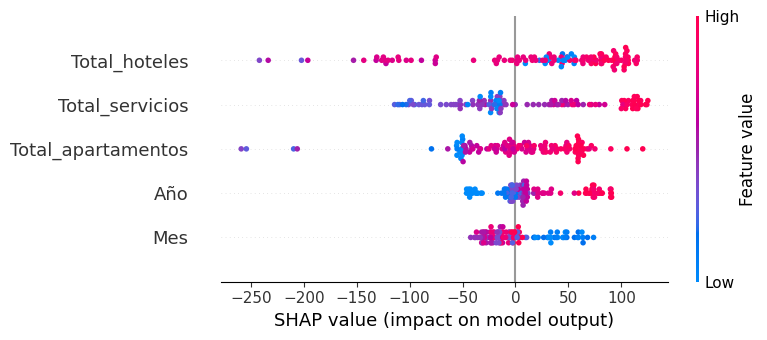

In [53]:
#Veamos que variables son más influyentes en cada modelo. 
explica_turis = shap.TreeExplainer(best_turis_rf) 
valore_turis = explica_turis.shap_values(X_turis) 

#Importancia de las variables 
shap.summary_plot(valore_turis, X_turis, plot_type = 'bar')

#Impacto de las variables 
shap.summary_plot(valore_turis, X_turis)

#Y ahora la interpretabilidad para los gastos. 
explica_gastos = shap.TreeExplainer(best_gas_rf)
valore_gastos = explica_gastos.shap_values(X_gas)

#Importancia de las variables 
shap.summary_plot(valore_gastos, X_gas, plot_type='bar')

#Impacto de las variables 
shap.summary_plot(valore_gastos, X_gas) 
